# Segmentation Comparison Stats

## Setup

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from pathlib import Path
import re
from scipy.ndimage import label as cc_label
import tifffile as tiff
import warnings


In [2]:
# data config

# model roots
MODEL_ROOTS = {
    "autumn": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds"),
    "autumn_overtrain": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_long/preds"),
    "expert": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds"),
    "random": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds"),
    "microsam_b": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_b/preds"),
    "microsam_l": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_l/preds"),
    "cellseg3d": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellseg3d/finetuned_cross_val/preds"),
    "cellpose2d": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellpose/cross_val/preds"),
    "cellpose3d": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellpose/cross_val/preds"),
    "nnunet": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/nnunet/cross_val/preds"),
    "unet_level3": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/unet_level3/finetuned_cross_val/preds"),
    "unet_level4": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/unet_level4/finetuned_cross_val/preds"),
    "unet_level5": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/unet_level5/finetuned_cross_val/preds"),
    "super_sweep2": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_super_sweep2/preds"),
    "unet_random2": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_unet_random2/preds"),
    "spring_sweep": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_spring_sweep/preds"),
    "unet_random3": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_unet_random3/preds"),
    "unet4": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_unet4/preds"),
    'bright_sweep': Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_bright_sweep_26/preds"),
    "unet_random4": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_unet_random4/preds"),
}

GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")
NNUNET_GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/compare_methods/nnunet/cross_val/raw")

DATA_TYPES = ["amyloid_plaque", "c_fos_positive", "cell_nucleus", "vessels"]

DATA_TYPE_TO_GT_SUBDIR = {
    "amyloid_plaque": "amyloid_plaque_patches",
    "c_fos_positive": "c_fos_positive_patches",
    "cell_nucleus": "cell_nucleus_patches",
    "vessels": "vessels_patches",
}

OUTPUT_DIR = Path("/midtier/paetzollab/scratch/ads4015/segmentation_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PROB_THRESHOLD = 0.5
STRUCT_3D_26 = np.ones((3, 3, 3), dtype=bool)


In [3]:
# display config

MODEL_DISPLAY = {
    "autumn": "SwinUNETR Image+CLIP",
    "autumn_overtrain": "SwinUNETR Image+CLIP (Overtrain)",
    "expert": "SwinUNETR Image-only",
    "random": "SwinUNETR Random-init",
    "microsam_b": "microSAM-B",
    "microsam_l": "microSAM-L",
    "cellseg3d": "CellSeg3D",
    "cellpose2d": "Cellpose-SAM (2D)",
    "cellpose3d": "Cellpose-SAM (3D)",
    "nnunet": "nnU-Net",
    "unet_level3": "U-Net (level 3)",
    "unet_level4": "U-Net (level 4)",
    "unet_level5": "U-Net (level 5)",
    "super_sweep2": "U-Net Image+CLIP",
    "unet_random2": "U-Net Random-init",
    "spring_sweep": "U-Net Image+CLIP (new)",
    "unet_random3": "U-Net Random-init (new)",
    "unet4": "U-Net Image+CLIP (new 2)",
    "bright_sweep": "U-Net Image-only",
    "unet_random4": "U-Net Random-init (new 2)",
}

MODEL_ORDER = [
    "autumn",
    "autumn_overtrain",
    "expert",
    "random",
    "microsam_b",
    "microsam_l",
    "cellseg3d",
    "cellpose2d",
    "cellpose3d",
    "nnunet",
    "unet_level3",
    "unet_level4",
    "unet_level5",
    "super_sweep2",
    "unet_random2",
    "spring_sweep",
    "unet_random3",
    "unet4",
    "bright_sweep",
    "unet_random4",
]

DEFAULT_PLOT_METRICS = ["total_dice", "foreground_dice", "instance_dice"]

MODEL_COLOR = {
    # SwinUNETR baselines
    "autumn": "blue",
    "autumn_overtrain": "navy",
    "expert": "cornflowerblue",
    "random": "blue",

    # microSAM
    "microsam_b": "darkgreen",
    "microsam_l": "teal",

    # other methods
    "cellseg3d": "hotpink",
    "cellpose2d": "limegreen",
    "cellpose3d": "lightgreen",
    "nnunet": "gold",

    # UNet depth sweep
    "unet_level3": "navajowhite",
    "unet_level4": "sandybrown",
    "unet_level5": "peru",

    # UNet backbone variants
    "super_sweep2": "red",
    "unet_random2": "red",
    "spring_sweep": "darkred",
    "unet_random3": "darkred",
    "unet4": "dimgray",
    "bright_sweep": "orange",
    "unet_random4": "dimgray",
}

MODEL_MARKER = {
    # SwinUNETR baselines
    "autumn": "o",
    "autumn_overtrain": "o",
    "expert": "s",
    "random": "X",

    # microSAM
    "microsam_b": "^",
    "microsam_l": "^",

    # other methods
    "cellseg3d": "p",
    "cellpose2d": "D",
    "cellpose3d": "D",
    "nnunet": "P",

    # UNet depth sweep
    "unet_level3": "*",
    "unet_level4": "*",
    "unet_level5": "*",

    # UNet backbone variants
    "super_sweep2": "o",
    "unet_random2": "X",
    "spring_sweep": "o",
    "unet_random3": "X",
    "unet4": "o",
    "bright_sweep": "s",
    "unet_random4": "X",
}

MODEL_LINESTYLE = {
    # SwinUNETR baselines
    "autumn": "-",
    "autumn_overtrain": "-",
    "expert": "-",
    "random": "--",

    # microSAM
    "microsam_b": "-",
    "microsam_l": "-",

    # other methods
    "cellseg3d": "-",
    "cellpose2d": "-",
    "cellpose3d": "-",
    "nnunet": "-",

    # UNet depth sweep
    "unet_level3": "-",
    "unet_level4": "-",
    "unet_level5": "-",

    # UNet backbone variants
    "super_sweep2": "-",
    "unet_random2": "--",
    "spring_sweep": "-",
    "unet_random3": "--",
    "unet4": "-",
    "bright_sweep": "-",
    "unet_random4": "--",
}


## Helper Functions

In [4]:
# nnunet helpers and configs

def normalize_registry_datatype(dt: str) -> str:
    return dt.replace("_patches", "") if dt.endswith("_patches") else dt

NNUNET_DATASET_REGISTRY = pd.read_csv(
    "/midtier/paetzollab/scratch/ads4015/compare_methods/nnunet/cross_val/dataset_registry.csv"
)

NNUNET_DATASET_ID_TO_TYPE = {
    int(row["dataset_id"]): normalize_registry_datatype(row["datatype"])
    for _, row in NNUNET_DATASET_REGISTRY.iterrows()
}

NNUNET_DATASET_ID_TO_NUM_TRAIN = {
    int(row["dataset_id"]): int(row["num_train"])
    for _, row in NNUNET_DATASET_REGISTRY.iterrows()
}


In [5]:
# data loading

def load_nifti(path: Path) -> np.ndarray:
    img = nib.load(str(path))
    return img.get_fdata(dtype=np.float32)

def _squeeze_singleton_channel(arr: np.ndarray) -> np.ndarray:
    return arr[0] if (arr.ndim == 4 and arr.shape[0] == 1) else arr

def _coerce_pred_gt_shapes(pred: np.ndarray, gt: np.ndarray):
    return _squeeze_singleton_channel(pred), _squeeze_singleton_channel(gt)


In [6]:
# filename parsing and gt paths

# filename patterns
PRED_NAME_RE = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_prob_.*\.nii\.gz$")
PRED_NAME_RE_MICROSAM_B = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)\.nii_pred_.*\.nii\.gz$")
PRED_NAME_RE_MICROSAM_L = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_pred_.*\.nii\.gz$")
PRED_STEM_RE_CELLSEG3D = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_instances$")
PRED_NAME_RE_CELLPOSE = re.compile(r"^patch_(\d+)_vol(\d+)_pred(2d|3d)_.*\.nii\.gz$")
PRED_NAME_RE_NNUNET = re.compile(r"^case_patch_(\d+)_vol(\d+)_ch(\d+)\.nii\.gz$")
PRED_NAME_RE_UNET = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_pred_.*\.nii\.gz$")

def parse_pred_name(pred_path: Path, model_name: str):
    if model_name == "microsam_b":
        m = PRED_NAME_RE_MICROSAM_B.match(pred_path.name)
        if m: return m.group(1), m.group(2), m.group(3)

    if model_name == "microsam_l":
        m = PRED_NAME_RE_MICROSAM_L.match(pred_path.name)
        if m: return m.group(1), m.group(2), m.group(3)

    if model_name == "cellseg3d":
        m = PRED_STEM_RE_CELLSEG3D.match(pred_path.stem)
        if m: return m.group(1), m.group(2), m.group(3)

    if model_name in ["cellpose2d", "cellpose3d"]:
        m = PRED_NAME_RE_CELLPOSE.match(pred_path.name)
        if not m:
            raise ValueError(f"Cannot parse cellpose filename: {pred_path}")
        patch_id, vol_id, mode = m.groups()
        ch_id = "0"
        if model_name == "cellpose2d" and mode != "2d":
            raise ValueError(f"Expected 2D pred, found 3D: {pred_path}")
        if model_name == "cellpose3d" and mode != "3d":
            raise ValueError(f"Expected 3D pred, found 2D: {pred_path}")
        return patch_id, vol_id, ch_id

    if model_name == "nnunet":
        m = PRED_NAME_RE_NNUNET.match(pred_path.name)
        if not m:
            raise ValueError(f"Cannot parse nnunet filename: {pred_path}")
        return m.group(1), m.group(2), m.group(3)

    if model_name in ["unet_level3", "unet_level4", "unet_level5"]:
        m = PRED_NAME_RE_UNET.match(pred_path.name)
        if m: return m.group(1), m.group(2), m.group(3)

    m = PRED_NAME_RE.match(pred_path.name)
    if m: return m.group(1), m.group(2), m.group(3)

    raise ValueError(f"Cannot parse prediction filename for model={model_name}: {pred_path}")

def build_gt_path(
    data_type: str,
    patch_id: str,
    vol_id: str,
    ch_id: str,
    model_name: str = None,
    cvfold_name: str = None,
) -> Path:
    if model_name == "nnunet":
        dataset_folder = NNUNET_GT_ROOT / cvfold_name / "labelsTs"
        gt_name = f"case_patch_{patch_id}_vol{vol_id}_ch{ch_id}.nii.gz"
        return dataset_folder / gt_name

    gt_subdir = DATA_TYPE_TO_GT_SUBDIR[data_type]
    gt_name = f"patch_{patch_id}_vol{vol_id}_ch{ch_id}_label.nii.gz"
    return (GT_ROOT / gt_subdir / gt_name)


In [7]:
# metrics

def binary_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return (2.0 * inter + eps) / (pred.sum() + gt.sum() + eps)

def background_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    pred_bg = np.logical_not(pred.astype(bool))
    gt_bg = np.logical_not(gt.astype(bool))
    inter = np.logical_and(pred_bg, gt_bg).sum()
    return (2.0 * inter + eps) / (pred_bg.sum() + gt_bg.sum() + eps)

def total_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    return 0.5 * (binary_dice(pred_bin, gt_bin, eps) + background_dice(pred_bin, gt_bin, eps))

def foreground_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    pred_bin = pred_bin.astype(bool)
    gt_bin = gt_bin.astype(bool)
    fg_union = np.logical_or(pred_bin, gt_bin)
    if fg_union.sum() == 0:
        return 1.0
    pred_f = pred_bin[fg_union]
    gt_f = gt_bin[fg_union]
    inter = np.logical_and(pred_f, gt_f).sum()
    return (2.0 * inter + eps) / (pred_f.sum() + gt_f.sum() + eps)

def count_instances(mask: np.ndarray, structure=STRUCT_3D_26) -> int:
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return 0
    _, n = cc_label(mask, structure=structure)
    return int(n)

def compute_metrics_for_pair(pred_path: Path, gt_path: Path) -> dict:
    if pred_path.suffix == ".tif":
        pred_arr = tiff.imread(str(pred_path)).astype(np.float32)
    else:
        pred_arr = load_nifti(pred_path)

    gt_arr = load_nifti(gt_path)
    pred_arr, gt_arr = _coerce_pred_gt_shapes(pred_arr, gt_arr)

    pred_bin = pred_arr >= PROB_THRESHOLD
    gt_bin = gt_arr > 0.5

    if pred_bin.shape != gt_bin.shape:
        raise ValueError(f"Shape mismatch: pred {pred_bin.shape}, gt {gt_bin.shape}")

    td = total_dice(pred_bin, gt_bin)
    fd = foreground_dice(pred_bin, gt_bin)
    n_pred = count_instances(pred_bin)
    n_gt = count_instances(gt_bin)

    inst_dice = 1.0 if (n_pred == 0 and n_gt == 0) else (2.0 * min(n_pred, n_gt)) / float(n_pred + n_gt)

    return {
        "total_dice": float(td),
        "foreground_dice": float(fd),
        "instance_dice": float(inst_dice),
        "instances_pred": int(n_pred),
        "instances_gt": int(n_gt),
    }


In [8]:
# get preds

# prediction discovery
def discover_pred_files(model_name: str, model_root: Path, data_type: str):
    
    # CellSeg3D only for cell_nucleus
    if model_name == "cellseg3d" and data_type != "cell_nucleus":
        return []

    # microSAM
    if model_name.startswith("microsam"):
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type]
        if not type_root.is_dir():
            return []
        out = []
        for fold_dir in sorted(type_root.iterdir()):
            if not fold_dir.is_dir():
                continue
            if model_name == "microsam_b" and not fold_dir.name.startswith("fold_cv"):
                continue
            if model_name == "microsam_l" and not fold_dir.name.startswith("cvfold"):
                continue
            preds_dir = fold_dir / "patches"
            if not preds_dir.is_dir():
                continue
            for pred_path in sorted(preds_dir.glob("patch_*.nii.gz")):
                out.append((pred_path, fold_dir.name))
        return out

    # CellSeg3D TIFFs
    if model_name == "cellseg3d":
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type]
        if not type_root.is_dir():
            return []
        out = []
        for fold_dir in sorted(type_root.iterdir()):
            if fold_dir.is_dir() and fold_dir.name.startswith("cvfold"):
                for pred_path in sorted(fold_dir.glob("*_instances.tif")):
                    out.append((pred_path, fold_dir.name))
        return out

    # Cellpose (only nucleus)
    if model_name in ["cellpose2d", "cellpose3d"]:
        if data_type != "cell_nucleus":
            return []
        type_root = model_root / "cell_nucleus_patches"
        if not type_root.is_dir():
            return []
        out = []
        for fold_dir in sorted(type_root.iterdir()):
            if fold_dir.is_dir() and fold_dir.name.startswith("cvfold"):
                for pred_path in sorted(fold_dir.glob("patch_*_pred*.nii.gz")):
                    if model_name == "cellpose2d" and "_pred2d_" not in pred_path.name:
                        continue
                    if model_name == "cellpose3d" and "_pred3d_" not in pred_path.name:
                        continue
                    out.append((pred_path, fold_dir.name))
        return out

    # nnU-Net
    if model_name == "nnunet":
        out = []
        for dataset_dir in sorted(model_root.glob("Dataset*")):
            if not dataset_dir.is_dir():
                continue
            cvfold_name = dataset_dir.name
            dataset_id = int(cvfold_name.replace("Dataset", ""))
            if dataset_id not in NNUNET_DATASET_ID_TO_TYPE:
                continue
            if NNUNET_DATASET_ID_TO_TYPE[dataset_id] != data_type:
                continue
            for pred_path in sorted(dataset_dir.glob("case_patch_*_vol*_ch*.nii.gz")):
                out.append((pred_path, cvfold_name))
        return out

    # UNet level3/4/5 (GT-style folder names)
    if model_name in ["unet_level3", "unet_level4", "unet_level5"]:
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type]
        if not type_root.is_dir():
            return []
        out = []
        for fold_dir in sorted(type_root.iterdir()):
            if fold_dir.is_dir() and fold_dir.name.startswith("cvfold"):
                for pred_path in sorted(fold_dir.glob("patch_*_pred_*.nii.gz")):
                    out.append((pred_path, fold_dir.name))
        return out

    # Default (autumn/expert/random/super_sweep/unet_random etc.)
    type_root = model_root / data_type
    if not type_root.is_dir():
        return []
    out = []
    for fold_dir in sorted(type_root.iterdir()):
        if fold_dir.is_dir() and fold_dir.name.startswith("cvfold"):
            preds_dir = fold_dir / "preds"
            if preds_dir.is_dir():
                for pred_path in sorted(preds_dir.glob("*_prob_*.nii.gz")):
                    out.append((pred_path, fold_dir.name))
    return out


# train size extraction
def extract_train_size(model_name: str, cvfold_name: str) -> float:
    if model_name == "microsam_b":
        m = re.search(r"_pool(\d+)_", cvfold_name)
        if m: return int(m.group(1))
        m = re.search(r"_ntr(\d+)_", cvfold_name)
        if m: return int(m.group(1))
        return np.nan

    if model_name == "nnunet" and cvfold_name.startswith("Dataset"):
        dataset_id = int(cvfold_name.replace("Dataset", ""))
        return NNUNET_DATASET_ID_TO_NUM_TRAIN.get(dataset_id, np.nan)

    m = re.search(r"_ntr(\d+)_", cvfold_name)
    return int(m.group(1)) if m else np.nan


# collect all metrics
def collect_all_metrics(models=MODEL_ROOTS, data_types=DATA_TYPES) -> pd.DataFrame:
    rows = []

    for model_name, model_root in models.items():
        print(f"[INFO] model={model_name} root={model_root}")
        for dt in data_types:
            pred_items = discover_pred_files(model_name, model_root, dt)
            for pred_path, cvfold_name in pred_items:
                try:
                    patch_id, vol_id, ch_id = parse_pred_name(pred_path, model_name)
                    gt_path = build_gt_path(dt, patch_id, vol_id, ch_id, model_name=model_name, cvfold_name=cvfold_name)
                    if not gt_path.is_file():
                        continue
                    metrics = compute_metrics_for_pair(pred_path, gt_path)
                except Exception as e:
                    warnings.warn(f"{model_name}/{dt}: {pred_path.name}: {e}")
                    continue

                # coarse cvfold id
                parts = cvfold_name.split("_")
                if len(parts) >= 2 and parts[0] == "fold" and parts[1].startswith("cv"):
                    cvfold_id = "_".join(parts[:2])   # fold_cv0
                else:
                    cvfold_id = parts[0]              # cvfold0 / Dataset####
                
                rows.append({
                    "model": model_name,
                    "data_type": dt,
                    "cvfold": cvfold_name,
                    "cvfold_id": cvfold_id,
                    "train_size": extract_train_size(model_name, cvfold_name),
                    "patch_id": patch_id,
                    "vol_id": vol_id,
                    "channel_id": ch_id,
                    "pred_path": str(pred_path),
                    "gt_path": str(gt_path),
                    **metrics,
                })

    return pd.DataFrame(rows)


In [9]:
# function to create plotting dataframes
def make_plotting_dataframes(
    collect_fn,
    output_dir=None,
    metric_cols=None,
    dropna_train_size=True,
    save_csv=True,
    verbose=True,
):
    """
    Create dataframes for plotting segmentation results.

    This function:
      1) runs collect_all_metrics()
      2) creates fold-level means
      3) creates train-size-level means (recommended for plotting)

    Parameters
    ----------
    collect_fn : callable
        Function that returns metrics_df (e.g. collect_all_metrics).
    output_dir : Path or None
        Directory to save CSVs. If None, nothing is saved.
    metric_cols : list[str] or None
        Metrics to aggregate. Defaults to standard dice + instance counts.
    dropna_train_size : bool
        Drop rows where train_size is NaN before aggregation.
    save_csv : bool
        Whether to save CSV outputs (requires output_dir).
    verbose : bool
        Print progress info.

    Returns
    -------
    metrics_df : pd.DataFrame
        Per-file metrics.
    summary_fold : pd.DataFrame
        Per-(model, data_type, cvfold, train_size) means.
    summary_train : pd.DataFrame
        Per-(model, data_type, train_size) means (best for plotting).
    """
    # --------------------
    # 1) Collect raw metrics
    # --------------------
    metrics_df = collect_fn()

    if verbose:
        print("[INFO] metrics_df rows:", len(metrics_df))
        display(metrics_df.head())

    # --------------------
    # 2) Metric columns
    # --------------------
    if metric_cols is None:
        metric_cols = [
            "total_dice",
            "foreground_dice",
            "instance_dice",
            "instances_pred",
            "instances_gt",
        ]

    metric_cols = [c for c in metric_cols if c in metrics_df.columns]

    if not metric_cols:
        raise ValueError("No valid metric columns found in metrics_df.")

    # --------------------
    # 3) Optional NaN handling
    # --------------------
    df = metrics_df.copy()
    if dropna_train_size:
        df = df.dropna(subset=["train_size"])

    # --------------------
    # 4) Fold-level aggregation
    # --------------------
    summary_fold = (
        df
        .groupby(
            ["model", "data_type", "cvfold", "train_size"],
            as_index=False
        )[metric_cols]
        .mean()
    )

    # --------------------
    # 5) Train-size-level aggregation
    # --------------------
    summary_train = (
        summary_fold
        .groupby(
            ["model", "data_type", "train_size"],
            as_index=False
        )[metric_cols]
        .mean()
    )

    # --------------------
    # 6) Save outputs
    # --------------------
    if save_csv and output_dir is not None:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

        raw_csv = output_dir / "selma3d_segmentation_metrics_per_file.csv"
        fold_csv = output_dir / "summary_by_model_type_and_fold_train_size.csv"
        train_csv = output_dir / "summary_by_model_type_and_train_size.csv"

        metrics_df.to_csv(raw_csv, index=False)
        summary_fold.to_csv(fold_csv, index=False)
        summary_train.to_csv(train_csv, index=False)

        if verbose:
            print("[saved]", raw_csv)
            print("[saved]", fold_csv)
            print("[saved]", train_csv)

    return metrics_df, summary_fold, summary_train


In [10]:
# plotting function
def plot_results(
    data_type: str,
    df=None,
    models=None,
    metrics=("total_dice", "foreground_dice", "instance_dice"),
    xlim=None,                 # (xmin, xmax)
    use_trendline=True,
    show_points=True,
    figsize=(7, 5),
    title_prefix="",
    legend_outside=False,
):
    """
    Plot metric(s) vs train_size for a given data_type.

    Parameters
    ----------
    data_type : str
        One of DATA_TYPES (e.g. "amyloid_plaque", "vessels").
    df : pd.DataFrame or None
        DataFrame to plot from. Recommended: summary_train.
        Must contain columns: ["model","data_type","train_size", <metrics...>].
        If None, will try summary_train then metrics_df (if present in globals()).
    models : list[str] or None
        Models to plot. Can be internal keys (e.g. "autumn") OR display names (e.g. "Image+CLIP").
        None -> uses all available models in canonical MODEL_ORDER.
    metrics : list[str]
        Metric columns to plot, e.g. ["foreground_dice"] or ["total_dice","instance_dice"].
    xlim : tuple(int|float, int|float) or None
        If provided, clamp x-range (xmin, xmax).
    use_trendline : bool
        Fit and draw a linear trendline per model (on visible points only).
    show_points : bool
        Scatter points.
    figsize : tuple
        Figure size per metric.
    title_prefix : str
        Optional prefix for plot title (e.g., "Segmentation").
    """
    # ---------
    # pick df
    # ---------
    if df is None:
        if "summary_train" in globals():
            df = globals()["summary_train"]
        elif "metrics_df" in globals():
            df = globals()["metrics_df"]
        else:
            raise ValueError("No df provided and neither summary_train nor metrics_df exists in globals().")

    required = {"model", "data_type", "train_size"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df is missing required columns: {missing}")

    # ---------
    # filter dtype
    # ---------
    d = df[df["data_type"] == data_type].copy()
    d = d.dropna(subset=["train_size"])
    if d.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # ---------
    # metric validation
    # ---------
    metrics = list(metrics) if isinstance(metrics, (list, tuple)) else [metrics]
    metrics = [m for m in metrics if m in d.columns]
    if not metrics:
        raise ValueError("None of the requested metrics exist in df.")

    # ---------
    # allow models to be internal keys OR display names
    # ---------
    # Create reverse map: display -> key
    display_to_key = {v: k for k, v in MODEL_DISPLAY.items()}

    if models is None:
        # default: all models present, in canonical order
        present = set(d["model"].unique().tolist())
        models_keys = [m for m in MODEL_ORDER if m in present]
    else:
        models_keys = []
        for m in models:
            if m in MODEL_ROOTS:               # internal key
                models_keys.append(m)
            elif m in display_to_key:          # display name
                models_keys.append(display_to_key[m])
            else:
                # try raw passthrough (in case df has different keys)
                models_keys.append(m)

        # keep canonical order when possible
        models_keys = [m for m in MODEL_ORDER if m in models_keys] + [m for m in models_keys if m not in MODEL_ORDER]

    # filter models
    d = d[d["model"].isin(models_keys)].copy()
    if d.empty:
        print("[WARN] After filtering models, no rows remain.")
        return

    # ---------
    # x-limits
    # ---------
    all_x = sorted(d["train_size"].unique().tolist())
    if xlim is None:
        xmin, xmax = min(all_x), max(all_x)
    else:
        xmin, xmax = xlim

    # ---------
    # plotting
    # ---------
    for metric in metrics:
        plt.figure(figsize=figsize)

        for model in models_keys:
            sub = d[d["model"] == model].copy()
            if sub.empty:
                continue

            x = sub["train_size"].astype(float).values
            y = sub[metric].astype(float).values

            # clamp to visible range
            mask = (x >= xmin) & (x <= xmax)
            x, y = x[mask], y[mask]
            if len(x) == 0:
                continue

            label = MODEL_DISPLAY.get(model, model)
            color = MODEL_COLOR.get(model, None)
            marker = MODEL_MARKER.get(model, "o")
            linestyle = MODEL_LINESTYLE.get(model, "-")

            if show_points:
                plt.scatter(x, y, label=label, color=color, marker=marker, alpha=0.85)

            if use_trendline and len(np.unique(x)) > 1:
                coef = np.polyfit(x, y, 1)
                poly = np.poly1d(coef)
                xs = np.linspace(xmin, xmax, 200)
                plt.plot(xs, poly(xs), color=color, linestyle=linestyle, alpha=0.9)

        pretty_dt = data_type.replace("_", " ").title()
        pretty_m = metric.replace("_", " ").title()
        prefix = (title_prefix + " — ") if title_prefix else ""
        plt.title(f"{prefix}{pretty_dt}: {pretty_m} vs Train size")

        plt.xlabel("Train size")
        plt.ylabel(pretty_m)
        plt.grid(True, linestyle="--", alpha=0.35)
        if legend_outside:
            plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0, frameon=False)
        else:
            plt.legend()

        # nicer integer ticks if possible
        visible_x = [v for v in all_x if xmin <= v <= xmax]
        if len(visible_x) <= 30:
            plt.xticks(visible_x)

        pad = max(1, 0.05 * (xmax - xmin)) if xmax > xmin else 1
        plt.xlim(xmin - pad, xmax + pad)

        if legend_outside:
            plt.tight_layout(rect=(0, 0, 0.82, 1))
        else:
            plt.tight_layout()
            
        plt.show()


## Show plots

In [11]:
# create dataframes
metrics_df, summary_fold, summary_train = make_plotting_dataframes(
    collect_fn=collect_all_metrics,
    output_dir=OUTPUT_DIR,
)


[INFO] model=autumn root=/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds
[INFO] model=autumn_overtrain root=/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_long/preds
[INFO] model=expert root=/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds
[INFO] model=random root=/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds
[INFO] model=microsam_b root=/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_b/preds
[INFO] model=microsam_l root=/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_l/preds
[INFO] model=cellseg3d root=/midtier/paetzollab/scratch/ads4015/compare_methods/cellseg3d/finetuned_cross_val/preds
[INFO] model=cellpose2d root=/midtier/paetzollab/scratch/ads4015/compare_methods/cellpose/cross_val/preds
[INFO] model=cellpose3d root=/midtier/paetzollab/scratch/ads4015/compare_me

,model,data_type,cvfold,cvfold_id,train_size,patch_id,vol_id,channel_id,pred_path,gt_path,total_dice,foreground_dice,instance_dice,instances_pred,instances_gt
0,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,10,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.494605,0.004194,0.001367,4385,3
1,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,10,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.477488,0.000287,0.000239,8377,1
2,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,11,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.688691,0.377570,0.500000,1,3
3,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,11,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.670949,0.341969,0.400000,4,1
4,autumn,amyloid_plaque,cvfold0_ntr12_nev2_fttr10_ftval2_fold0_trlim12...,cvfold0,12,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.657598,0.315412,0.800000,2,3


[saved] /midtier/paetzollab/scratch/ads4015/segmentation_results/selma3d_segmentation_metrics_per_file.csv
[saved] /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_type_and_fold_train_size.csv
[saved] /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_type_and_train_size.csv


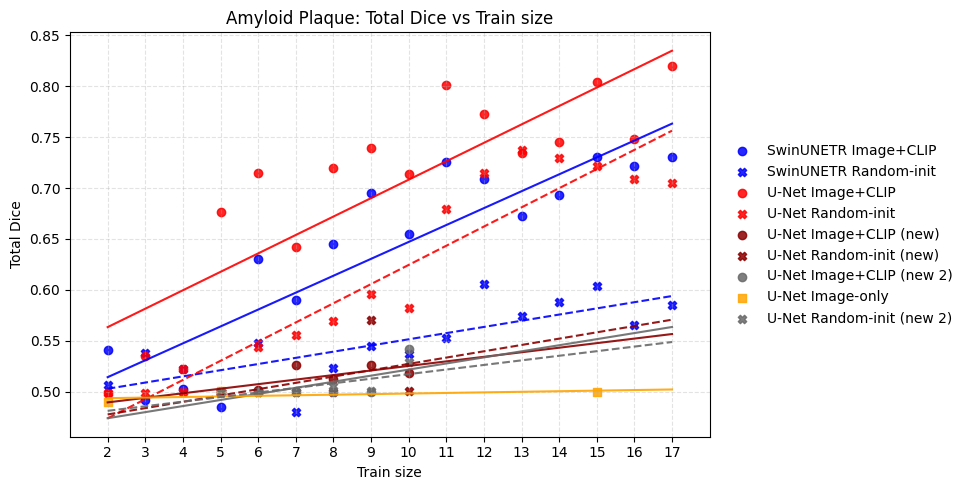

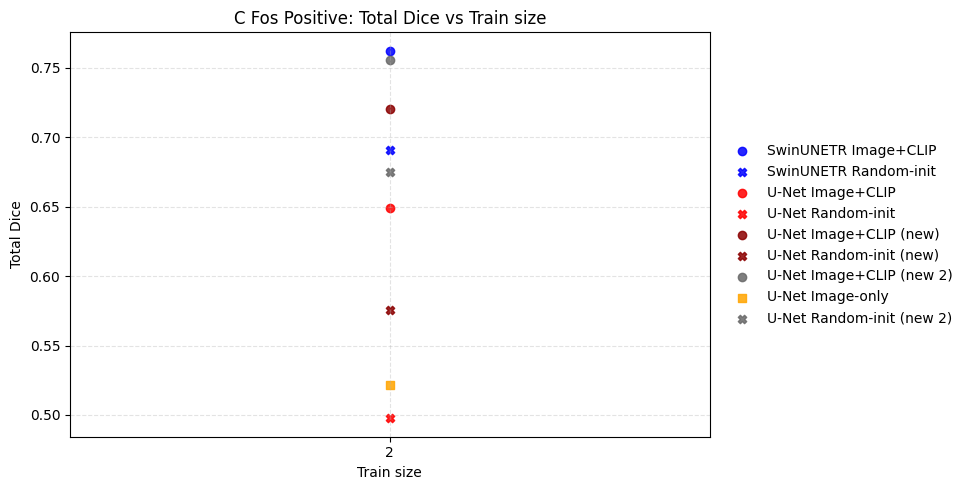

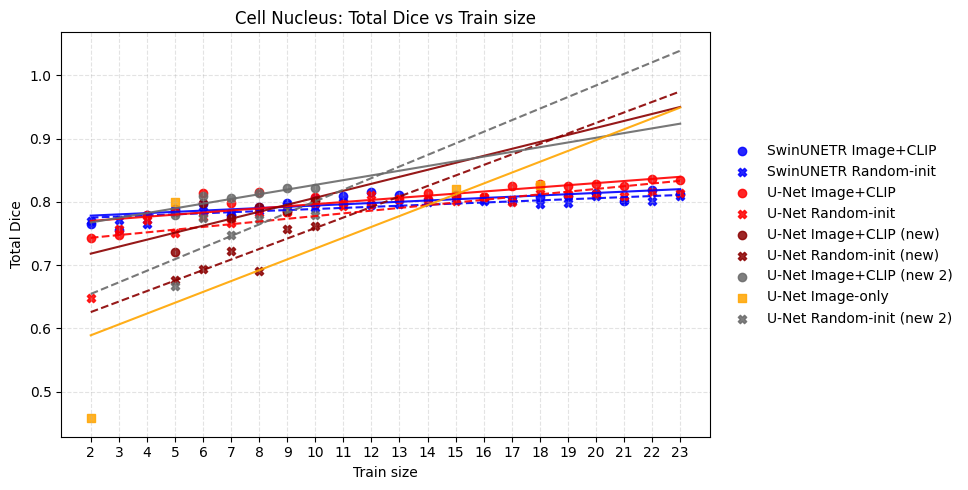

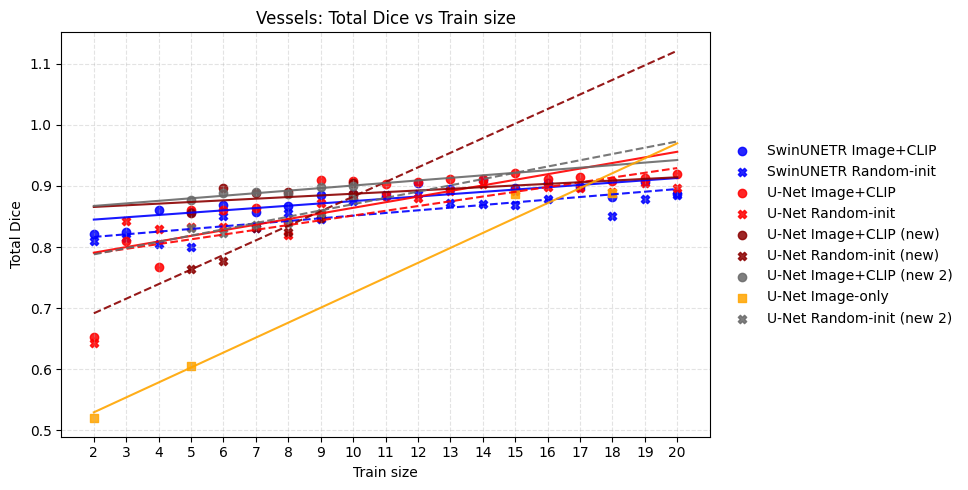

In [12]:
for dtype in DATA_TYPES:
    plot_results(
        data_type=dtype,
        df=summary_train,
        models=["autumn", "random", 
                "super_sweep2", "unet_random2", "spring_sweep", "unet_random3", "unet4", "bright_sweep", "unet_random4"],
        metrics=["total_dice"],
        # xlim=(1, 3) if dtype == 'c_fos_positive' else (5, 10),
        legend_outside=True,
        figsize=(12, 5)
    )


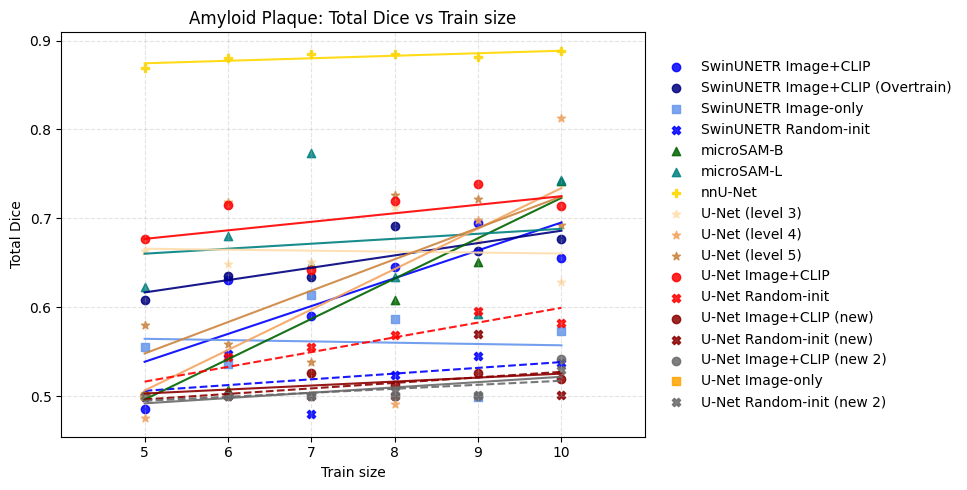

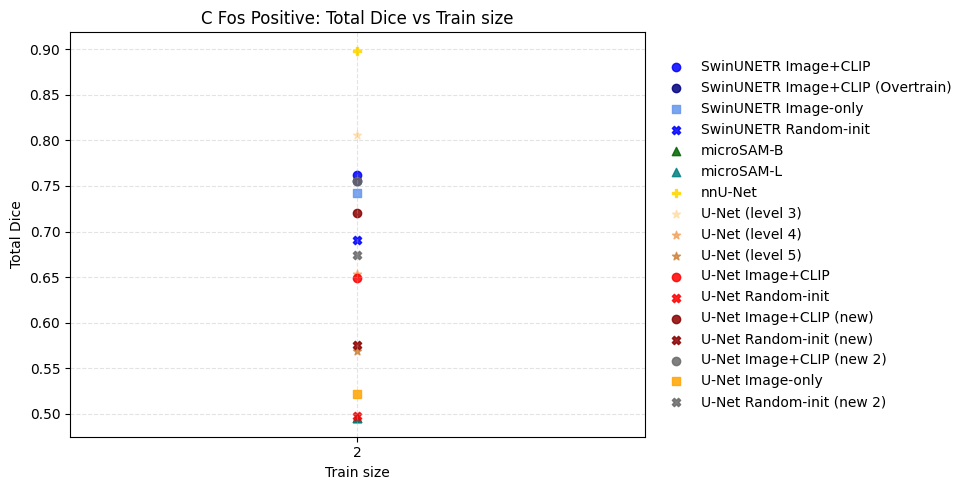

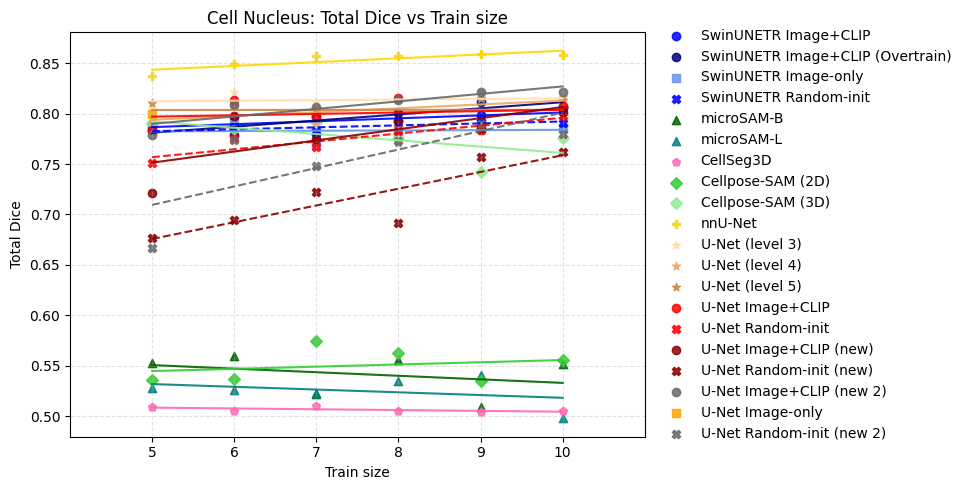

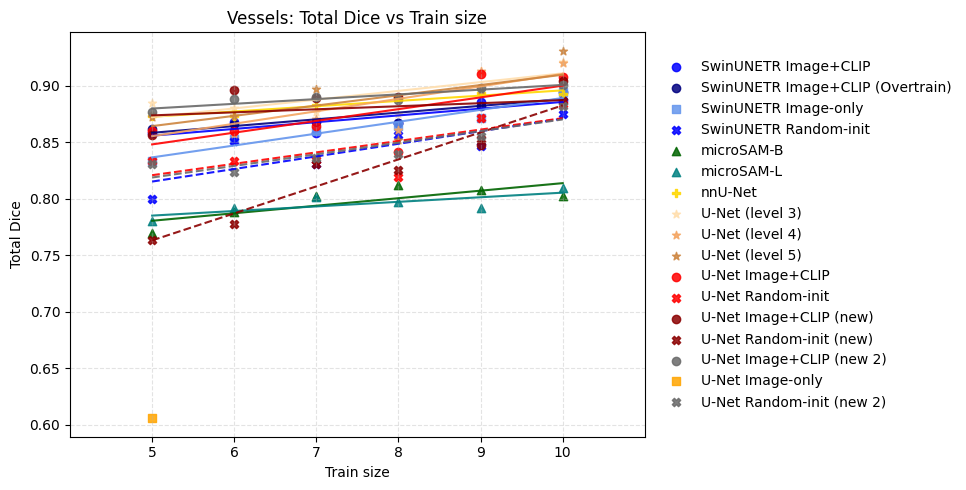

In [13]:
for dtype in DATA_TYPES:
    plot_results(
        data_type=dtype,
        df=summary_train,
        metrics=["total_dice"],
        xlim=(1, 3) if dtype == 'c_fos_positive' else (5, 10),
        legend_outside=True,
        figsize=(12, 5)
    )
    

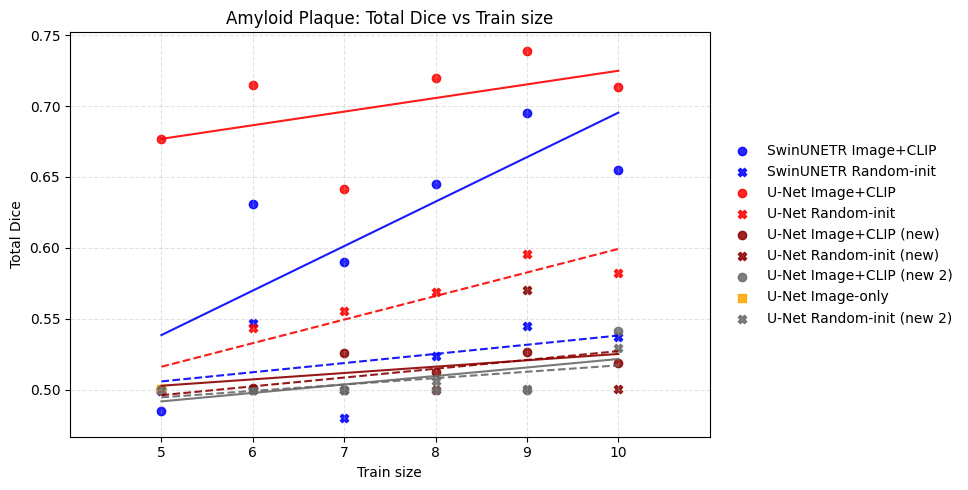

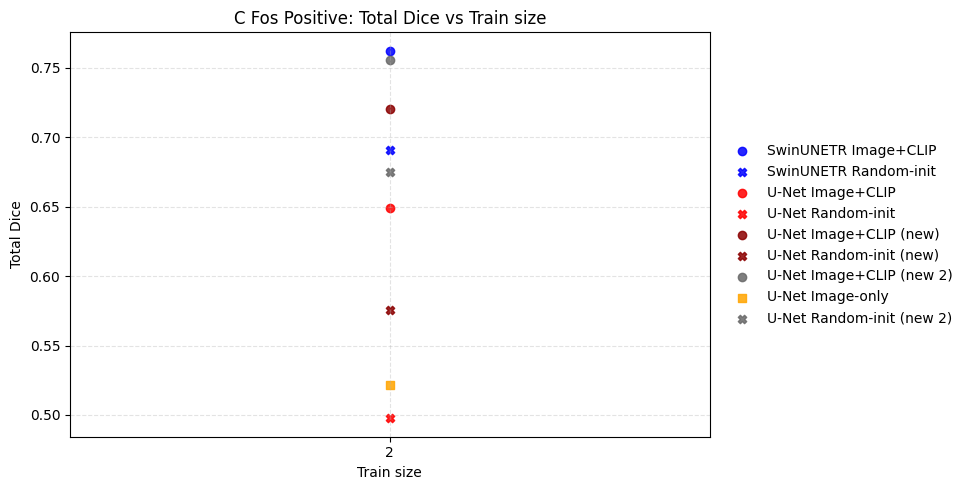

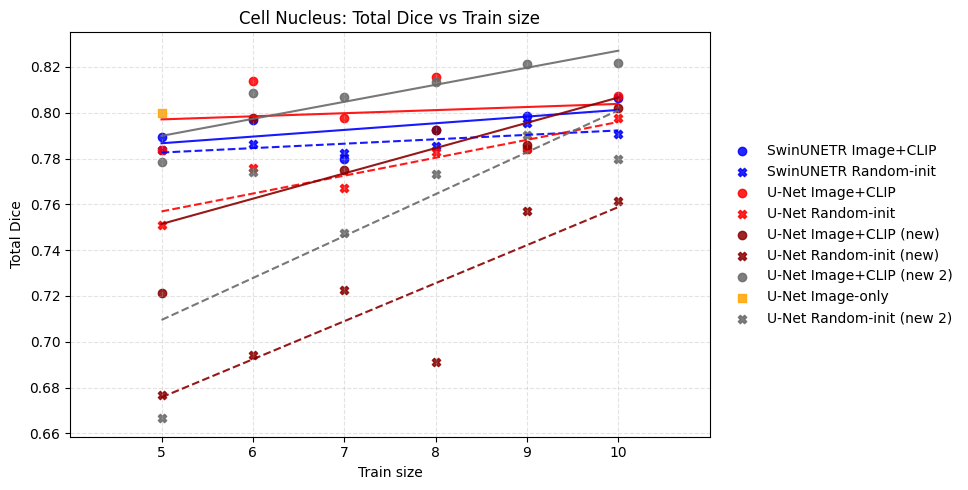

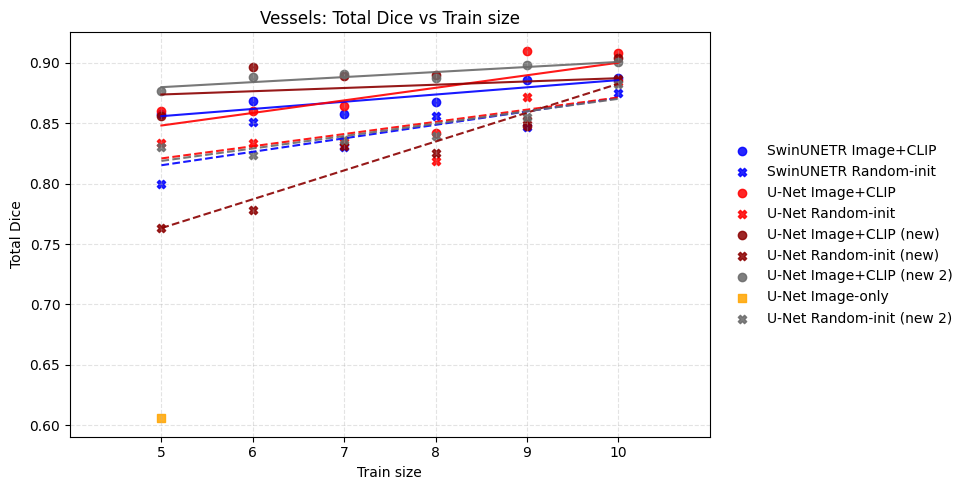

In [14]:
for dtype in DATA_TYPES:
    plot_results(
        data_type=dtype,
        df=summary_train,
        models=["autumn", "random", 
                "super_sweep2", "unet_random2", "spring_sweep", "unet_random3", "unet4", "bright_sweep", "unet_random4"],
        metrics=["total_dice"],
        xlim=(1, 3) if dtype == 'c_fos_positive' else (5, 10),
        legend_outside=True,
        figsize=(12, 5)
    )


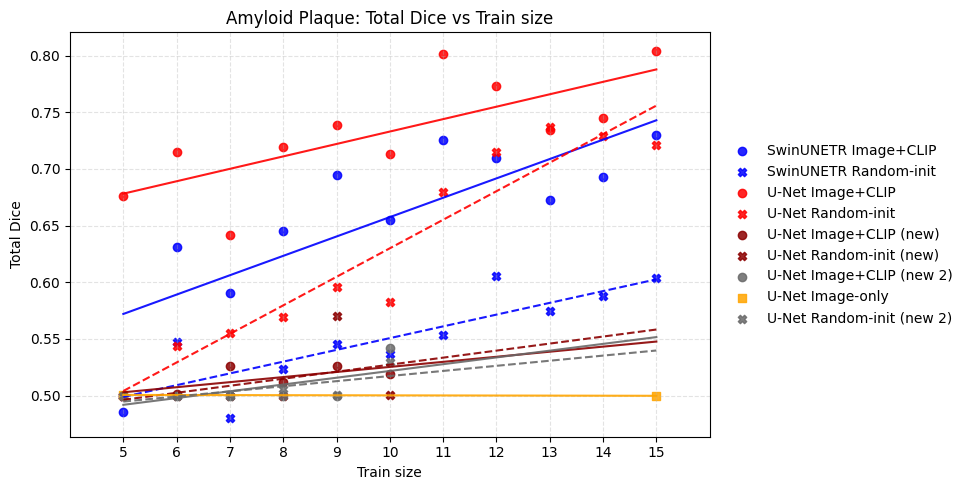

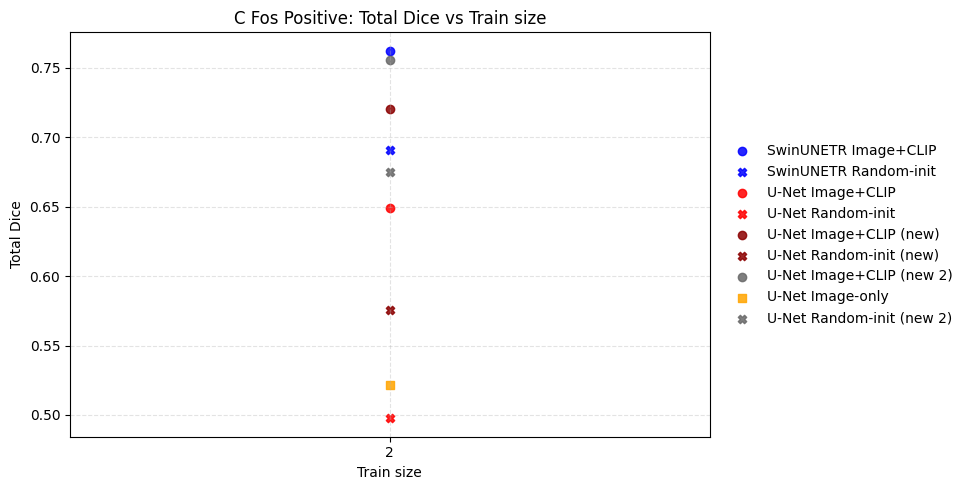

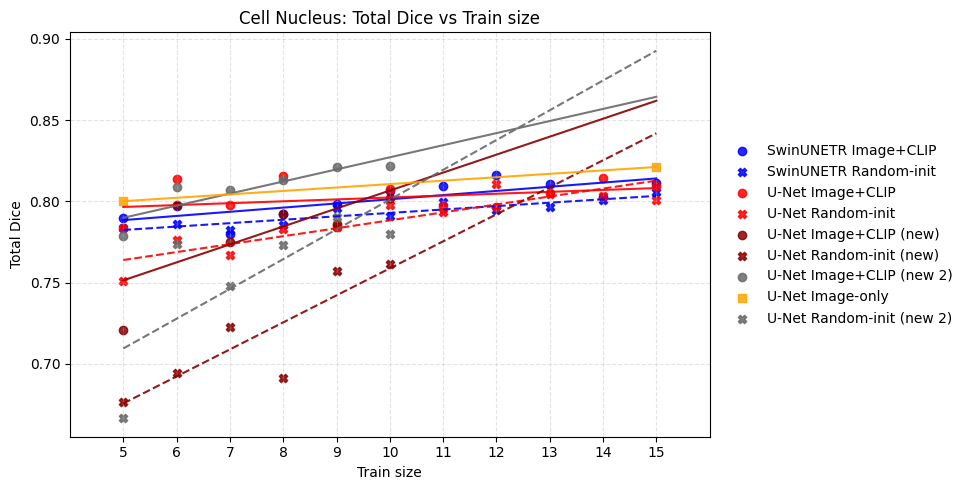

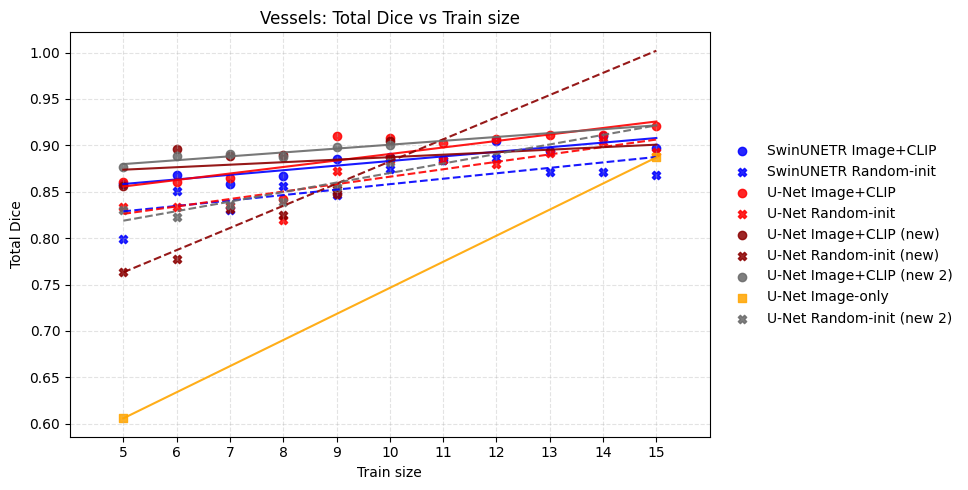

In [15]:
for dtype in DATA_TYPES:
    plot_results(
        data_type=dtype,
        df=summary_train,
        models=["autumn", "random", 
                "super_sweep2", "unet_random2", "spring_sweep", "unet_random3", "unet4", "bright_sweep", "unet_random4"],
        metrics=["total_dice"],
        xlim=(1, 3) if dtype == 'c_fos_positive' else (5, 15),
        legend_outside=True,
        figsize=(12, 5)
    )
